## 1. Cài đặt và import các thư viện cần thiết

In [1]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import random
import numpy as np
import shutil
import time
import copy
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import seaborn as sns
import matplotlib.pyplot as plt

## 2. Định nghĩa lớp và Tải dữ liệu

In [3]:
# Lớp AIDDataset tùy chỉnh
class AIDDataset(Dataset):
    def __init__(self, image_paths, labels, classes, class_to_idx, transform=None):
        """
        image_paths: Danh sách đường dẫn đến ảnh
        labels: Danh sách nhãn tương ứng
        classes: Danh sách tên các lớp
        class_to_idx: Ánh xạ từ tên lớp sang chỉ số
        transform: Các phép biến đổi (transforms) áp dụng lên ảnh
        """
        self.image_paths = image_paths
        self.labels = labels
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
def load_aid_data(root_dir):
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    image_paths, labels = [], []
    image_files = [[] for _ in range(len(classes))]

    for cls_idx, cls_name in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls_name)
        cls_images = [os.path.join(cls_dir, img_name) for img_name in os.listdir(cls_dir)
                     if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))]

        image_files[cls_idx] = cls_images
        image_paths.extend(cls_images)
        labels.extend([class_to_idx[cls_name]] * len(cls_images))

    return image_paths, labels, classes, class_to_idx, image_files

# Tải dữ liệu
data_dir = '/kaggle/input/aid-scene-classification-datasets/AID'
image_paths, labels, class_names, class_to_idx, image_files = load_aid_data(data_dir)

# In thông tin dataset
image_width, image_height = Image.open(image_paths[0]).size
print('Total image count:', len(image_paths))
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(len(class_names))])

Total image count: 10000
Image dimensions: 600 x 600
Label names: ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
Label counts: [360, 310, 220, 400, 360, 260, 240, 350, 410, 300, 370, 250, 390, 280, 290, 340, 350, 390, 370, 420, 380, 260, 290, 410, 300, 300, 330, 290, 360, 420]


## 3. Chia tập dữ liệu

In [5]:
# Đường dẫn dataset gốc và thư mục lưu kết quả
source_dataset_path = '/kaggle/input/aid-scene-classification-datasets/AID'
output_base_path = '/kaggle/working/split_aid_dataset'
train_dir = os.path.join(output_base_path, 'train')
val_dir = os.path.join(output_base_path, 'val')
test_dir = os.path.join(output_base_path, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Tải dataset
dataset = ImageFolder(source_dataset_path)
image_paths = [item[0] for item in dataset.samples]
labels = [item[1] for item in dataset.samples]
class_names = dataset.classes

# Phân loại ảnh theo từng lớp
class_images = {class_idx: [] for class_idx in range(len(class_names))}
for img_path, label in zip(image_paths, labels):
    class_images[label].append(img_path)

# Chia đều từng lớp theo tỷ lệ 6:2:2
train_paths, val_paths, test_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []

for class_idx, class_name in enumerate(class_names):
    images = class_images[class_idx]
    total_images = len(images)

    train_size = int(total_images * 0.6)
    val_size = int(total_images * 0.2)
    test_size = total_images - train_size - val_size

    # Điều chỉnh để tránh sai lệch do làm tròn
    if train_size + val_size + test_size > total_images:
        diff = train_size + val_size + test_size - total_images
        if val_size > diff:
            val_size -= diff
        else:
            test_size -= diff
    elif train_size + val_size + test_size < total_images:
        diff = total_images - (train_size + val_size + test_size)
        test_size += diff

    train_split = images[:train_size]
    val_split = images[train_size:train_size + val_size]
    test_split = images[train_size + val_size:]

    train_paths.extend(train_split)
    val_paths.extend(val_split)
    test_paths.extend(test_split)
    train_labels.extend([class_idx] * len(train_split))
    val_labels.extend([class_idx] * len(val_split))
    test_labels.extend([class_idx] * len(test_split))

# Sao chép ảnh vào thư mục đích với cấu trúc thư mục con theo lớp
def copy_images(image_paths, labels, dest_dir, class_names):
    for class_name in class_names:
        class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        dest_path = os.path.join(dest_dir, class_name, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

copy_images(train_paths, train_labels, train_dir, class_names)
copy_images(val_paths, val_labels, val_dir, class_names)
copy_images(test_paths, test_labels, test_dir, class_names)

# Phân phối lớp trong các tập
def print_class_distribution(labels, dataset_name):
    counts = Counter(labels)
    print(f"\nPhân phối lớp trong tập {dataset_name}:")
    for class_idx, count in counts.items():
        print(f"  - {class_names[class_idx]}: {count} ảnh")

print_class_distribution(train_labels, "Train")
print_class_distribution(val_labels, "Validation")
print_class_distribution(test_labels, "Test")

# Tổng số ảnh trong mỗi tập
print(f"\nTổng số ảnh trong tập Train: {len(train_paths)}")
print(f"Tổng số ảnh trong tập Validation: {len(val_paths)}")
print(f"Tổng số ảnh trong tập Test: {len(test_paths)}")


Phân phối lớp trong tập Train:
  - Airport: 216 ảnh
  - BareLand: 186 ảnh
  - BaseballField: 132 ảnh
  - Beach: 240 ảnh
  - Bridge: 216 ảnh
  - Center: 156 ảnh
  - Church: 144 ảnh
  - Commercial: 210 ảnh
  - DenseResidential: 246 ảnh
  - Desert: 180 ảnh
  - Farmland: 222 ảnh
  - Forest: 150 ảnh
  - Industrial: 234 ảnh
  - Meadow: 168 ảnh
  - MediumResidential: 174 ảnh
  - Mountain: 204 ảnh
  - Park: 210 ảnh
  - Parking: 234 ảnh
  - Playground: 222 ảnh
  - Pond: 252 ảnh
  - Port: 228 ảnh
  - RailwayStation: 156 ảnh
  - Resort: 174 ảnh
  - River: 246 ảnh
  - School: 180 ảnh
  - SparseResidential: 180 ảnh
  - Square: 198 ảnh
  - Stadium: 174 ảnh
  - StorageTanks: 216 ảnh
  - Viaduct: 252 ảnh

Phân phối lớp trong tập Validation:
  - Airport: 72 ảnh
  - BareLand: 62 ảnh
  - BaseballField: 44 ảnh
  - Beach: 80 ảnh
  - Bridge: 72 ảnh
  - Center: 52 ảnh
  - Church: 48 ảnh
  - Commercial: 70 ảnh
  - DenseResidential: 82 ảnh
  - Desert: 60 ảnh
  - Farmland: 74 ảnh
  - Forest: 50 ảnh
  - Industr

## 4. Biến đổi dữ liệu

In [6]:
base_dir = '/kaggle/working/split_aid_dataset'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
def load_dataset(root_dir, transform):
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} không tồn tại.")
    return datasets.ImageFolder(root=root_dir, transform=transform)

train_dataset = load_dataset(os.path.join(base_dir, 'train'), train_transforms)
val_dataset = load_dataset(os.path.join(base_dir, 'val'), val_test_transforms)
test_dataset = load_dataset(os.path.join(base_dir, 'test'), val_test_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

## 5. Khai báo mô hình

In [8]:
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.empty_cache()

num_classes = len(os.listdir(data_dir))

# Mô hình có pretrained
model = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=num_classes)
in_features = model.get_classifier().in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model.to(device)

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

## 6. Cấu hình và huấn luyện mô hình

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, SequentialLR
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import GradScaler, autocast

# Cấu hình mô hình huấn luyện
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5) 

num_epochs = 200
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, 
                       epochs=num_epochs, 
                       steps_per_epoch=steps_per_epoch,
                       pct_start=0.1, 
                       div_factor=50, 
                       final_div_factor=1e4, 
                       anneal_strategy='cos')

# Gradient scaler
scaler = GradScaler(device='cuda')

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=200, patience=10, checkpoint_path="checkpoint.pth"):

    start_epoch = 0
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    early_stop_counter = 0
    total_train_time = 0.0

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        if scheduler and "scheduler_state_dict" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_acc = checkpoint["best_acc"]
        best_model_wts = checkpoint["best_model_wts"]
        train_losses = checkpoint["train_losses"]
        val_losses = checkpoint["val_losses"]
        train_accs = checkpoint["train_accs"]
        val_accs = checkpoint["val_accs"]
        early_stop_counter = checkpoint["early_stop_counter"]
        total_train_time = checkpoint.get("total_train_time", 0.0)
        print(f"=> Resuming from epoch {start_epoch}, best val acc so far: {best_acc:.4f}")
        print(f"=> Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Huấn luyện
    for epoch in range(start_epoch, num_epochs):
        since = time.time()

        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # AMP
            with autocast('cuda'):  
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            # Gradient clipping (optional, 1.0 is typical value)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                preds = torch.argmax(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc.item())

        epoch_time = time.time() - since
        total_train_time += epoch_time
        log_str = (
            f"Epoch {epoch+1:03d} | "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
            f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
            f"Time: {epoch_time:.2f}s"
        )
        print(log_str)

        # Lưu mô hình tốt nhất
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            model.eval()
            torch.save(model.state_dict(), "best_model.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        if scheduler:
            scheduler.step()

        # Lưu checkpoint
        # epoch_time = time.time() - since
        # total_train_time += epoch_time
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_acc': best_acc,
            'best_model_wts': best_model_wts,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'early_stop_counter': early_stop_counter,
            'total_train_time': total_train_time
        }
        torch.save(checkpoint, checkpoint_path)

    print(f"\nTotal Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
    print(f"Best Val Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accs, val_accs), total_train_time

In [10]:
# Huấn luyện mô hình
model, history, total_train_time = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs=num_epochs,
    patience=10,
    checkpoint_path="checkpoint.pth"
)

Epoch 001 | Train Loss: 3.1745 | Train Acc: 0.1642 | Val Loss: 2.7281 | Val Acc: 0.4265 | LR: 0.000020 | Time: 55.47s
Epoch 002 | Train Loss: 2.3183 | Train Acc: 0.5343 | Val Loss: 2.0332 | Val Acc: 0.6675 | LR: 0.000020 | Time: 54.31s
Epoch 003 | Train Loss: 1.6561 | Train Acc: 0.7572 | Val Loss: 1.5139 | Val Acc: 0.8230 | LR: 0.000020 | Time: 54.36s
Epoch 004 | Train Loss: 1.2360 | Train Acc: 0.8615 | Val Loss: 1.2068 | Val Acc: 0.8725 | LR: 0.000020 | Time: 53.61s
Epoch 005 | Train Loss: 1.0242 | Train Acc: 0.9055 | Val Loss: 1.0395 | Val Acc: 0.8970 | LR: 0.000020 | Time: 54.10s
Epoch 006 | Train Loss: 0.9247 | Train Acc: 0.9273 | Val Loss: 0.9763 | Val Acc: 0.9115 | LR: 0.000020 | Time: 53.67s
Epoch 007 | Train Loss: 0.8639 | Train Acc: 0.9445 | Val Loss: 0.9361 | Val Acc: 0.9170 | LR: 0.000020 | Time: 53.77s
Epoch 008 | Train Loss: 0.8192 | Train Acc: 0.9582 | Val Loss: 0.9080 | Val Acc: 0.9220 | LR: 0.000020 | Time: 53.65s
Epoch 009 | Train Loss: 0.7900 | Train Acc: 0.9695 | Val

## 7. Đánh giá mô hình

### 7.1. Biểu đồ acc/loss theo epoch

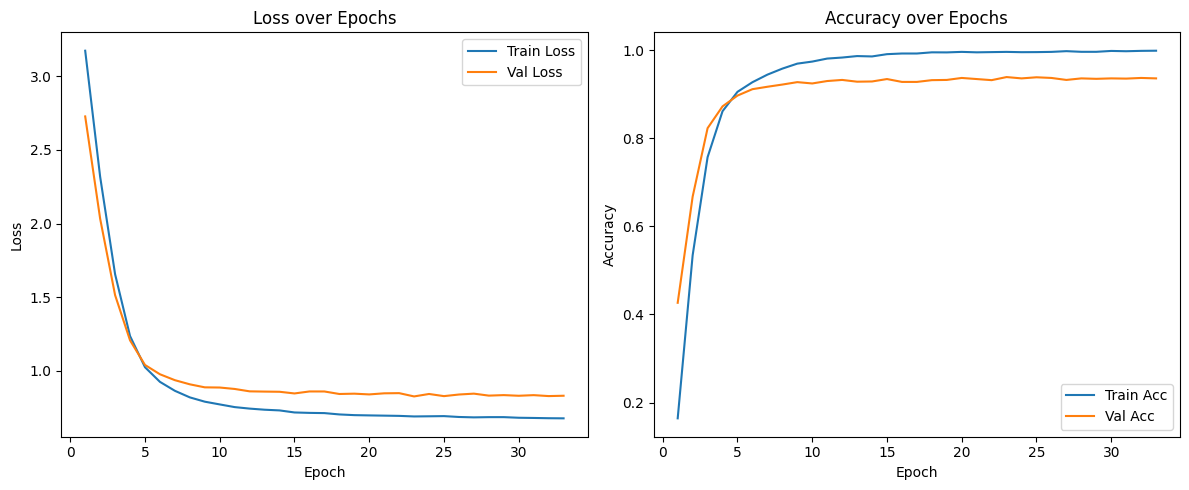

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

train_losses, val_losses, train_accs, val_accs = history

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plot_path = "training_metrics.png"
plt.savefig(plot_path)
plt.show()

### 7.2. Đánh giá trên tập test

In [12]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [19]:
# Độ chính xác cuối cùng (trên test set)
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9520


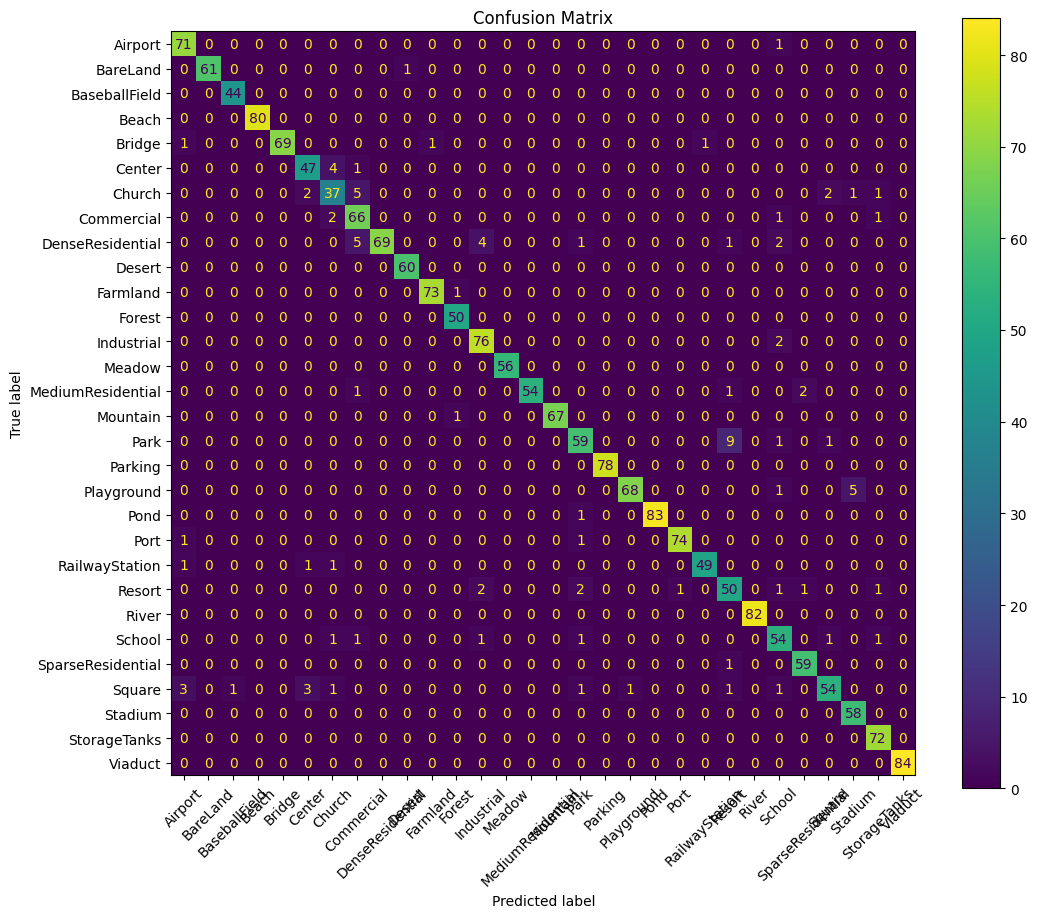

In [14]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(12, 10))
cmd.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
conf_matrix_path = "confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.show()

In [15]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

                   precision    recall  f1-score   support

          Airport       0.92      0.99      0.95        72
         BareLand       1.00      0.98      0.99        62
    BaseballField       0.98      1.00      0.99        44
            Beach       1.00      1.00      1.00        80
           Bridge       1.00      0.96      0.98        72
           Center       0.89      0.90      0.90        52
           Church       0.80      0.77      0.79        48
       Commercial       0.84      0.94      0.89        70
 DenseResidential       1.00      0.84      0.91        82
           Desert       0.98      1.00      0.99        60
         Farmland       0.99      0.99      0.99        74
           Forest       0.96      1.00      0.98        50
       Industrial       0.92      0.97      0.94        78
           Meadow       1.00      1.00      1.00        56
MediumResidential       1.00      0.93      0.96        58
         Mountain       1.00      0.99      0.99       

### 7.3. Đo thời gian inference

In [16]:
# Đo thời gian inference trên test set
def measure_inference_time(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)
    start_time = time.time()

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Inference

    total_time = time.time() - start_time
    num_images = len(test_dataset)
    avg_time_per_image = total_time / num_images
    print(f"[{device.upper()}] Average Inference Time per Image: {avg_time_per_image*1000:.2f} ms")
    return avg_time_per_image

# Chạy sau khi load model tốt nhất
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)

gpu_time = measure_inference_time(model, test_loader, device='cuda')
cpu_time = measure_inference_time(model, test_loader, device='cpu')

[CUDA] Average Inference Time per Image: 4.12 ms
[CPU] Average Inference Time per Image: 94.95 ms


## 8. Dự đoán 1 ảnh thực tế

In [17]:
def predict_image(image_path, model, transform, class_names, device):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    plt.imshow(image)
    plt.title(f'Predicted: {class_names[pred_label]}')
    plt.axis('off')
    plt.show()

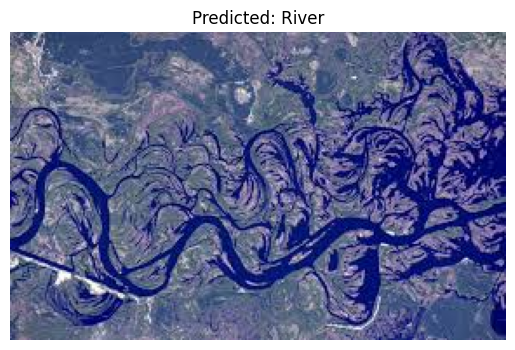

In [18]:
image_path = '/kaggle/input/scence-test/river.jpg'  # Đường dẫn ảnh
predict_image(image_path, model, val_test_transforms, train_dataset.classes, device)